참고 (딥러닝을 이용한 자연어 처리)
: https://wikidocs.net/94600

위 링크에는 keras framework로 신경망을 구현한 반면, 이번 과제에서는 **pytorch** framework로 구현해보도록 합니다.

참고 : https://www.deeplearningwizard.com/deep_learning/practical_pytorch/pytorch_recurrent_neuralnetwork/
https://wonhwa.tistory.com/35

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device}" " is available.")

cuda is available.


### 데이터 불러오기 (네이버 쇼핑 리뷰 감성 분석 데이터)

In [4]:
!pip install konlpy
!pip install mecab-python
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 63.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.1/494.1 kB 39.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.8/588.8 kB 16.1 MB/s eta 0:00:00
  Created wheel for mecab-python: filename=mecab_python-1.0.0-py3-none-any.whl size=1232 sha256=6ee4fa8adf9336adfdc7aee27fe2c4491cfb79290c9b6fb051b457da9f41a808
  Stored in directory: /root/.cache/pip/wheels/a0/56/2c/eac72592ca2e80bdc46ff47d1fb327629e2a24e8cdc5aaf95f
Successfully built mecab-python
Install mecab-ko
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1381k  100 1381k    0     0  1117k      0  0:00:01  0:00:01 --:--:-- 89.1M
mecab-0.996-ko-0.9.2/
mecab-0.996-ko-0.9.2/example/
mecab-0.996-ko-0.9.2/example/exam

In [5]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [6]:
# 데이터 로드하기
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")
total_data = pd.read_table('ratings_total.txt', names = ['ratings', 'reviews'])

# 데이터 개수 확인
print('리뷰 개수 : ', len(total_data))

리뷰 개수 :  200000


In [7]:
total_data[:5] # 상위 5개 데이터만 샘플로 확인

,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ


In [8]:
# 감성 분석을 위한 라벨링
total_data['label'] = np.select([total_data.ratings > 3], [1], default=0) # 4,5점은 긍정 1 / 1,2 점은 부정 0 으로 라벨링
total_data.drop_duplicates(subset=['reviews'], inplace=True) # 중복 제거

# 훈련 데이터와 테스트 데이터 split
train_data, test_data = train_test_split(total_data, test_size = 0.2, random_state = 42)

In [9]:
train_data['label'].value_counts()

,count
label,
1,80003
0,79923


### 데이터 정제 및 전처리

In [10]:
# 한글과 공백을 제외하고 모두 제거 (train)
# [^ㄱ-ㅎㅏ-ㅣ가-힣 ]: 정규 표현식으로, 한글(모음과 자음)과 띄어쓰기를 제외한 문자들을 매칭
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace('', np.nan, inplace=True)

# test data에도 동일하게 적용
test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거

<ipython-input-10-b3393058b13d>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['reviews'].replace('', np.nan, inplace=True)
<ipython-input-10-b3393058b13d>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', t

### 토큰화

In [11]:
# Mecab 모델로 형태소 분석 및 토큰화
mecab = Mecab()

# 불용어 설정
# stopword.txt 파일이 저장된 경로를 정확히 입력해주세요
with open('/content/drive/MyDrive/stopword.txt') as f:
    list_file = f.readlines()

stopwords_list = []
for stopword in list_file:
  stopwords = re.sub('[\n]', '', stopword)
  stopwords_list.append(stopwords)

# train data 토큰화
train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords_list])

# test data 토큰화
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords_list])

In [12]:
train_data[:5]

,ratings,reviews,label,tokenized
132466,1,바디버든 줄이려고 써보려고 샀는데 음용할수잇는 물로 헹궈야되면 왜 식기세척기 쓰나요?,0,"[바디, 버든, 줄이, 려고, 써, 보, 려고, 샀, 는데, 음용, 할, 수, 잇,..."
188461,2,시중에 판매하는 건새우랑 다르게 속살이 고루분포된게아니라 속이비어보이고 속살이 한쪽...,0,"[시중, 판매, 는, 건, 새, 우랑, 다르, 게, 속살, 고루, 분포, 된, 게,..."
124757,4,깔끔하니 이쁘네요 좋습니다,1,"[깔끔, 니, 이쁘, 네요, 좋]"
50357,2,사이즈미스! 남자가 쓰기엔 너무작네요,0,"[사이즈, 미스, !, 남자, 쓰, 기, 엔, 너무, 작, 네요]"
137655,4,좋은 상품 빠르고 안전한 배송 감사합니다,1,"[좋, 은, 상품, 빠르, 고, 안전, 한, 배송, 감사, 합니다]"


### 정수 인코딩

In [13]:
# train과 test를 위한 X,Y data 분류

X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

In [14]:
# 단어 집합 생성 및 정수 인코딩
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [15]:
# vocab_size 설정
vocab_size = len(tokenizer.word_index)

# 텍스트 시퀀스 -> 정수 시퀀스
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

### 패딩




In [16]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))

리뷰의 최대 길이 : 88
리뷰의 평균 길이 : 17.15400872903718


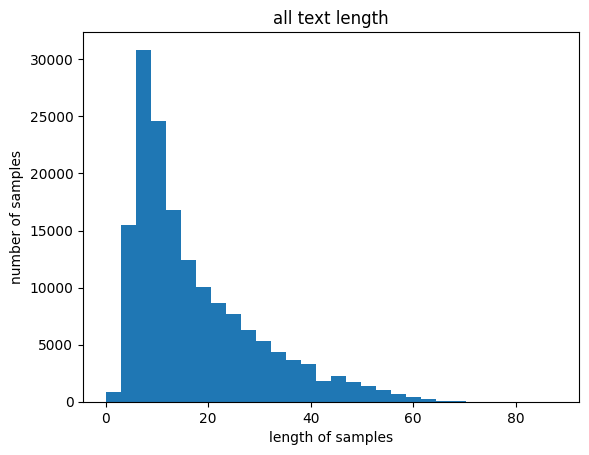

In [17]:
import matplotlib.pyplot as plt

num_tokens = [len(review) for review in X_train]

plt.title('all text length')
plt.hist(num_tokens, bins=30)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [18]:
select_length = 40

def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1

    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

below_threshold_len(select_length, X_train)

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9337005865212661


In [19]:
# 최대 길이를 40으로 잡고 패딩
max_len = 40
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

### 퀴즈

문제: 패딩을 하는 이유는 무엇일까요? (어떤 경우에 사용하는지 생각해보세요)

답변: 샘플의 길이가 너무 짧을 때 패딩을 하여 길이를 늘릴 수 있다. 또한 길이가 같아야 행렬 연산 등 다양한 계산이 용이하므로 패딩을 해 길이를 맞춰주는 것이다.


In [20]:
# model 변경 함수
def get_model(model, model_params):
    models = {
        "rnn": RNNModel,
        "lstm": LSTMModel,
        "gru": GRUModel,
    }
    return models.get(model.lower())(**model_params)

### DataLoader 생성

In [21]:
from torch.utils.data import Dataset, DataLoader

class LabeledNumpyArrayDataset(Dataset):
    def __init__(self, numpy_data, numpy_labels, transform=None):
        self.data = numpy_data
        self.labels = numpy_labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        label = self.labels[index]

        if self.transform:
            sample = self.transform(sample)

        return sample, label

In [22]:
batch_size = 64

# 레이블링된 데이터셋 객체 생성
train_dataset = LabeledNumpyArrayDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = LabeledNumpyArrayDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

### 모델 학습 (Vanilla RNN)

In [23]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, dropout_prob, device):
        super(RNNModel, self).__init__()
        self.device = device
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.rnn = nn.RNN(
            embedding_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )
        # Fully connected layer
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)

        h0 = torch.zeros(self.layer_dim, text.size(0), self.hidden_dim).requires_grad_()
        h0 = h0.to(self.device)
        out, h0 = self.rnn(embedded, h0.detach())

        # 현재 out의 차원은 (batch_size, seq_length, hidden_size)입니다.
        # 이를 fully connected layer에 fit하게 차원을 변경(batch_size, hidden_size)해주어야 합니다.
        out = out[:, -1, :] # 64 x 64 size

        """
        문제 1: 이제 out을 우리가 원하는 ouput_dim 차원으로 변환해주어야 합니다.
        빈칸에 들어갈 인스턴스 변수를 채워넣어주세요.
        """
        out = self.fc(out)
        return out

In [24]:
num_epoch = 15
batch_size = 64
embedding_dim = 64
hidden_dim = 64
layer_dim = 1
output_dim = 4

model = RNNModel(vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, 0.5, device)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr= 0.005)


"""
문제 2: RNN에서 loss를 계산하는 기준은 무엇일까요? 빈칸에 알맞은 답을 적어주세요
"""
criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


In [25]:
iter = 0
for epoch in range(num_epoch):
    for i, (text, labels) in enumerate(train_dataloader):
        model.train()

        text = text.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = model(text).to(device)



        """
        문제2: loss를 구하기 위해서 위에서 정의한 변수 중 무엇을 사용하면 될까요? 빈칸을 채워넣어주세요.
        """
        loss = criterion(logits, labels)

        loss.backward()

        """
        문제3: 역전파를 거친 후 매개변수(가중치)를 업데이트하기 위해서 필요한 메서드는 무엇이었나요?
        빈칸을 채워넣어주세요.
        """
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            model.eval()
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for test_text, test_labels in test_dataloader:
                test_text = test_text.to(device)
                test_labels = test_labels.to(device)
                # Forward pass only to get logits/output
                outputs = model(test_text)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += test_labels.size(0)

                # Total correct predictions
                correct += (predicted == test_labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 0.4850912094116211. Accuracy: 82.51463317871094
Iteration: 1000. Loss: 0.3405766189098358. Accuracy: 87.60942840576172
Iteration: 1500. Loss: 0.4177855849266052. Accuracy: 88.10714721679688
Iteration: 2000. Loss: 0.2586585283279419. Accuracy: 89.30268859863281
Iteration: 2500. Loss: 0.4886276423931122. Accuracy: 88.1296615600586
Iteration: 3000. Loss: 0.37199535965919495. Accuracy: 87.80200958251953
Iteration: 3500. Loss: 0.2573090195655823. Accuracy: 87.474365234375
Iteration: 4000. Loss: 0.1947452872991562. Accuracy: 88.94752502441406
Iteration: 4500. Loss: 0.25165367126464844. Accuracy: 88.60987854003906
Iteration: 5000. Loss: 0.30638226866722107. Accuracy: 89.50778198242188
Iteration: 5500. Loss: 0.21405911445617676. Accuracy: 89.0500717163086
Iteration: 6000. Loss: 0.2878093719482422. Accuracy: 88.03961944580078
Iteration: 6500. Loss: 0.1901809126138687. Accuracy: 88.18468475341797
Iteration: 7000. Loss: 0.3681176006793976. Accuracy: 88.21720123291016
Iterati

### 모델학습 (LSTM, Long short term memory)

In [26]:
class LSTMModel(nn.Module):

    def __init__(self,vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, dropout_prob, device):
        super(LSTMModel, self).__init__()

        self.device = device

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # LSTM layers
        self.lstm = nn.LSTM(
            embedding_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)

        h0 = torch.zeros(self.layer_dim, text.size(0), self.hidden_dim).requires_grad_()
        h0 = h0.to(self.device)

        # 초기에 cell state를 영행렬로 초기화
        c0 = torch.zeros(self.layer_dim, text.size(0), self.hidden_dim).requires_grad_()
        c0 = c0.to(self.device)

        out, (hn, cn) = self.lstm(embedded, (h0.detach(), c0.detach()))

        # 현재 out의 차원은 (batch_size, seq_length, hidden_size)입니다.
        # 이를 fully connected layer에 fit하게 차원을 변경(batch_size, hidden_size)해주어야 합니다.
        out = out[:, -1, :]

        # fc layer를 통해 (batch_size, output_dim)로 차원을 변경해줍니다.
        out = self.fc(out)

        return out

In [27]:
num_epoch = 15
batch_size = 64
embedding_dim = 64
hidden_dim = 64
layer_dim = 1
output_dim = 4

model = LSTMModel(vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, 0.5, device)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr= 0.005)

criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


In [28]:
iter = 0
for epoch in range(num_epoch):
    for i, (text, labels) in enumerate(train_dataloader):
        model.train()

        text = text.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = model(text).to(device)

        loss = criterion(logits, labels)
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 1000 == 0:
            model.eval()
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for test_text, test_labels in test_dataloader:
                test_text = test_text.to(device)
                test_labels = test_labels.to(device)
                # Forward pass only to get logits/output
                outputs = model(test_text)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += test_labels.size(0)

                # Total correct predictions
                correct += (predicted == test_labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 1000. Loss: 0.28421106934547424. Accuracy: 90.94842529296875
Iteration: 2000. Loss: 0.33437779545783997. Accuracy: 91.4836654663086
Iteration: 3000. Loss: 0.19256985187530518. Accuracy: 91.56871032714844
Iteration: 4000. Loss: 0.1548018902540207. Accuracy: 91.62873077392578
Iteration: 5000. Loss: 0.20559252798557281. Accuracy: 91.98389434814453
Iteration: 6000. Loss: 0.15085665881633759. Accuracy: 91.8363265991211
Iteration: 7000. Loss: 0.2258421927690506. Accuracy: 91.5737075805664
Iteration: 8000. Loss: 0.12968645989894867. Accuracy: 91.40113067626953
Iteration: 9000. Loss: 0.1741841435432434. Accuracy: 91.58621215820312
Iteration: 10000. Loss: 0.13039039075374603. Accuracy: 91.42364501953125
Iteration: 11000. Loss: 0.13002723455429077. Accuracy: 91.2535629272461
Iteration: 12000. Loss: 0.17668531835079193. Accuracy: 91.2210464477539
Iteration: 13000. Loss: 0.13472315669059753. Accuracy: 90.98344421386719
Iteration: 14000. Loss: 0.17549793422222137. Accuracy: 90.9759368896

### 모델 학습 (Gated Recurrent Unit (GRU))

In [29]:
class GRUModel(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, dropout_prob, device):
        super(GRUModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.device = device
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # GRU layers
        self.gru = nn.GRU(
            embedding_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, text):

        embedded = self.embedding(text)

        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, text.size(0), self.hidden_dim).requires_grad_()
        h0 = h0.to(self.device)

        # Forward propagation by passing in the input and hidden state into the model
        out, _ = self.gru(embedded, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out


In [30]:
num_epoch = 15
batch_size = 64
embedding_dim = 64
hidden_dim = 64
layer_dim = 1
output_dim = 4

model = GRUModel(vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, 0.5, device)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr= 0.005)

criterion = nn.CrossEntropyLoss()

In [31]:
iter = 0
for epoch in range(num_epoch):
    for i, (text, labels) in enumerate(train_dataloader):
        model.train()

        text = text.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = model(text).to(device)
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(logits, labels)
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 1000 == 0:
            model.eval()
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for test_text, test_labels in test_dataloader:
                test_text = test_text.to(device)
                test_labels = test_labels.to(device)
                # Forward pass only to get logits/output
                outputs = model(test_text)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += test_labels.size(0)

                # Total correct predictions
                correct += (predicted == test_labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 1000. Loss: 0.28463509678840637. Accuracy: 91.0234603881836
Iteration: 2000. Loss: 0.2623039484024048. Accuracy: 91.49867248535156
Iteration: 3000. Loss: 0.3292994201183319. Accuracy: 91.57621002197266
Iteration: 4000. Loss: 0.2724841237068176. Accuracy: 91.69376373291016
Iteration: 5000. Loss: 0.20462949573993683. Accuracy: 91.71627044677734
Iteration: 6000. Loss: 0.09938694536685944. Accuracy: 91.69876861572266
Iteration: 7000. Loss: 0.08677905797958374. Accuracy: 91.58121490478516
Iteration: 8000. Loss: 0.15720562636852264. Accuracy: 91.28607940673828
Iteration: 9000. Loss: 0.2042333483695984. Accuracy: 91.33360290527344
Iteration: 10000. Loss: 0.1674596518278122. Accuracy: 91.19353485107422
Iteration: 11000. Loss: 0.17436642944812775. Accuracy: 91.01345825195312
Iteration: 12000. Loss: 0.10250134021043777. Accuracy: 90.9909439086914
Iteration: 13000. Loss: 0.10044407844543457. Accuracy: 90.6532974243164
Iteration: 14000. Loss: 0.15551064908504486. Accuracy: 90.8233718872

## 모델 성능 비교

옵티마이저, 파라미터 등을 바꿔가며 모델의 성능을 향상시켜보세요.

이후 세 가지 모델의 성능 차이를 비교하고, 자유롭게 해석해보세요!

1. 옵티마이저 수정, NADAM을 사용

이유: NADAM은 ADAM에 Nesterov 모멘텀을 사용하여 미리 기울기를 예측하고 업데이트하는 방식으로 흘러간다. 이미 기울기를 예측했고 실제 기울기도 그와 비슷하다면 불필요한 계산량을 줄일 수 있어 정확하고 효율적으로 작동할 것이라 생각했다.

In [32]:
#RNN

num_epoch = 15
batch_size = 64
embedding_dim = 64
hidden_dim = 64
layer_dim = 1
output_dim = 4

model_rnn = RNNModel(vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, 0.5, device)
model_rnn = model.to(device)

criterion = nn.CrossEntropyLoss()

iter = 0
for epoch in range(num_epoch):
    for i, (text, labels) in enumerate(train_dataloader):
        model.train()

        text = text.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = model(text).to(device)

        loss = criterion(logits, labels)
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 1000 == 0:
            model.eval()
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for test_text, test_labels in test_dataloader:
                test_text = test_text.to(device)
                test_labels = test_labels.to(device)
                # Forward pass only to get logits/output
                outputs = model(test_text)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += test_labels.size(0)

                # Total correct predictions
                correct += (predicted == test_labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 1000. Loss: 0.09183845669031143. Accuracy: 89.94547271728516
Iteration: 2000. Loss: 0.16341720521450043. Accuracy: 89.88044738769531
Iteration: 3000. Loss: 0.2339836061000824. Accuracy: 90.30813598632812
Iteration: 4000. Loss: 0.1050831601023674. Accuracy: 90.33065032958984
Iteration: 5000. Loss: 0.031839460134506226. Accuracy: 90.3231430053711
Iteration: 6000. Loss: 0.17396177351474762. Accuracy: 90.26811981201172
Iteration: 7000. Loss: 0.12331291288137436. Accuracy: 90.23060607910156
Iteration: 8000. Loss: 0.04380621016025543. Accuracy: 89.97299194335938
Iteration: 9000. Loss: 0.14671766757965088. Accuracy: 89.92797088623047
Iteration: 10000. Loss: 0.1521180123090744. Accuracy: 89.93547058105469
Iteration: 11000. Loss: 0.15425728261470795. Accuracy: 90.19308471679688
Iteration: 12000. Loss: 0.04829121753573418. Accuracy: 89.90045928955078
Iteration: 13000. Loss: 0.16462008655071259. Accuracy: 89.98799896240234
Iteration: 14000. Loss: 0.07869228720664978. Accuracy: 90.11054

In [33]:
# LSTM

num_epoch = 15
batch_size = 64
embedding_dim = 64
hidden_dim = 64
layer_dim = 1
output_dim = 4

model_lstm = LSTMModel(vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, 0.5, device)
model_lstm = model.to(device)
optimizer = torch.optim.NAdam(model.parameters(), lr= 0.005)

criterion = nn.CrossEntropyLoss()

iter = 0
for epoch in range(num_epoch):
    for i, (text, labels) in enumerate(train_dataloader):
        model.train()

        text = text.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = model(text).to(device)

        loss = criterion(logits, labels)
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 1000 == 0:
            model.eval()
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for test_text, test_labels in test_dataloader:
                test_text = test_text.to(device)
                test_labels = test_labels.to(device)
                # Forward pass only to get logits/output
                outputs = model(test_text)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += test_labels.size(0)

                # Total correct predictions
                correct += (predicted == test_labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 1000. Loss: 0.0864630788564682. Accuracy: 90.07303619384766
Iteration: 2000. Loss: 0.11654859781265259. Accuracy: 90.21309661865234
Iteration: 3000. Loss: 0.16875959932804108. Accuracy: 89.8404312133789
Iteration: 4000. Loss: 0.17605581879615784. Accuracy: 89.99800109863281
Iteration: 5000. Loss: 0.07483901083469391. Accuracy: 89.91546630859375
Iteration: 6000. Loss: 0.07498988509178162. Accuracy: 89.82542419433594
Iteration: 7000. Loss: 0.12677447497844696. Accuracy: 89.75788879394531
Iteration: 8000. Loss: 0.16904348134994507. Accuracy: 89.6728515625
Iteration: 9000. Loss: 0.1376388818025589. Accuracy: 89.95047760009766
Iteration: 10000. Loss: 0.11147011071443558. Accuracy: 89.9854965209961
Iteration: 11000. Loss: 0.13464359939098358. Accuracy: 89.98799896240234
Iteration: 12000. Loss: 0.09112545102834702. Accuracy: 89.91546630859375
Iteration: 13000. Loss: 0.054655008018016815. Accuracy: 89.9029541015625
Iteration: 14000. Loss: 0.0210257638245821. Accuracy: 89.59031677246

In [34]:
#GRU


num_epoch = 15
batch_size = 64
embedding_dim = 64
hidden_dim = 64
layer_dim = 1
output_dim = 4

model_gru = GRUModel(vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, 0.5, device)
model_gru = model.to(device)
optimizer = torch.optim.NAdam(model.parameters(), lr= 0.005)

criterion = nn.CrossEntropyLoss()

iter = 0
for epoch in range(num_epoch):
    for i, (text, labels) in enumerate(train_dataloader):
        model.train()

        text = text.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = model(text).to(device)

        loss = criterion(logits, labels)
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 1000 == 0:
            model.eval()
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for test_text, test_labels in test_dataloader:
                test_text = test_text.to(device)
                test_labels = test_labels.to(device)
                # Forward pass only to get logits/output
                outputs = model(test_text)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += test_labels.size(0)

                # Total correct predictions
                correct += (predicted == test_labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 1000. Loss: 0.10349644720554352. Accuracy: 89.6728515625
Iteration: 2000. Loss: 0.06917022168636322. Accuracy: 89.7904052734375
Iteration: 3000. Loss: 0.30477312207221985. Accuracy: 89.54279327392578
Iteration: 4000. Loss: 0.07192035764455795. Accuracy: 89.56781005859375
Iteration: 5000. Loss: 0.21839551627635956. Accuracy: 89.5102767944336
Iteration: 6000. Loss: 0.099001944065094. Accuracy: 89.3752212524414
Iteration: 7000. Loss: 0.18549448251724243. Accuracy: 89.36021423339844
Iteration: 8000. Loss: 0.16891443729400635. Accuracy: 89.42274475097656
Iteration: 9000. Loss: 0.08171795308589935. Accuracy: 89.5152816772461
Iteration: 10000. Loss: 0.06592023372650146. Accuracy: 89.55280303955078
Iteration: 11000. Loss: 0.0602852925658226. Accuracy: 89.24266052246094
Iteration: 12000. Loss: 0.14285175502300262. Accuracy: 89.55280303955078
Iteration: 13000. Loss: 0.1435968279838562. Accuracy: 89.34770965576172
Iteration: 14000. Loss: 0.08444658666849136. Accuracy: 89.31769561767578


오히려 NADAM이 성능이 더 낮게 나옴을 확인할 수 있었다. 따라서 파라미터를 조정해보기로 했다. iter와 epoch은 크게할수록 성능이 더 좋게 나오는 경우가 많으므로 차원과 배치 사이즈를 조정해보기로 한다.


In [35]:
#RNN

num_epoch = 15
batch_size = 32
embedding_dim = 32
hidden_dim = 32
layer_dim = 1
output_dim = 4

model_rnn = RNNModel(vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, 0.5, device)
model_rnn = model.to(device)
optimizer = torch.optim.NAdam(model.parameters(), lr= 0.005)

criterion = nn.CrossEntropyLoss()

iter = 0
for epoch in range(num_epoch):
    for i, (text, labels) in enumerate(train_dataloader):
        model.train()

        text = text.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = model(text).to(device)

        loss = criterion(logits, labels)
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 1000 == 0:
            model.eval()
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for test_text, test_labels in test_dataloader:
                test_text = test_text.to(device)
                test_labels = test_labels.to(device)
                # Forward pass only to get logits/output
                outputs = model(test_text)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += test_labels.size(0)

                # Total correct predictions
                correct += (predicted == test_labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 1000. Loss: 0.09489177167415619. Accuracy: 89.36021423339844
Iteration: 2000. Loss: 0.16544991731643677. Accuracy: 89.22014617919922
Iteration: 3000. Loss: 0.08630337566137314. Accuracy: 89.40023040771484
Iteration: 4000. Loss: 0.10716705024242401. Accuracy: 89.14761352539062
Iteration: 5000. Loss: 0.19731587171554565. Accuracy: 89.30018615722656
Iteration: 6000. Loss: 0.08198066800832748. Accuracy: 89.50277709960938
Iteration: 7000. Loss: 0.08176521211862564. Accuracy: 89.46276092529297
Iteration: 8000. Loss: 0.0750647708773613. Accuracy: 89.2626724243164
Iteration: 9000. Loss: 0.13231971859931946. Accuracy: 89.48027038574219
Iteration: 10000. Loss: 0.06652908027172089. Accuracy: 89.44024658203125
Iteration: 11000. Loss: 0.09215975552797318. Accuracy: 89.60782623291016
Iteration: 12000. Loss: 0.12231095880270004. Accuracy: 89.26016998291016
Iteration: 13000. Loss: 0.10960400104522705. Accuracy: 89.06758117675781
Iteration: 14000. Loss: 0.06690632551908493. Accuracy: 89.3427

In [36]:
# LSTM

num_epoch = 15
batch_size = 32
embedding_dim = 32
hidden_dim = 32
layer_dim = 1
output_dim = 4

model_lstm = LSTMModel(vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, 0.5, device)
model_lstm = model.to(device)
optimizer = torch.optim.NAdam(model.parameters(), lr= 0.005)

criterion = nn.CrossEntropyLoss()

iter = 0
for epoch in range(num_epoch):
    for i, (text, labels) in enumerate(train_dataloader):
        model.train()

        text = text.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = model(text).to(device)

        loss = criterion(logits, labels)
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 1000 == 0:
            model.eval()
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for test_text, test_labels in test_dataloader:
                test_text = test_text.to(device)
                test_labels = test_labels.to(device)
                # Forward pass only to get logits/output
                outputs = model(test_text)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += test_labels.size(0)

                # Total correct predictions
                correct += (predicted == test_labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 1000. Loss: 0.07145199179649353. Accuracy: 89.4027328491211
Iteration: 2000. Loss: 0.0973479300737381. Accuracy: 89.35520935058594
Iteration: 3000. Loss: 0.08613704144954681. Accuracy: 89.0550765991211
Iteration: 4000. Loss: 0.09077032655477524. Accuracy: 89.1401138305664
Iteration: 5000. Loss: 0.1835724264383316. Accuracy: 89.32019805908203
Iteration: 6000. Loss: 0.14373879134655. Accuracy: 88.95753479003906
Iteration: 7000. Loss: 0.15355153381824493. Accuracy: 88.8699951171875
Iteration: 8000. Loss: 0.14094768464565277. Accuracy: 88.82997131347656
Iteration: 9000. Loss: 0.11888883262872696. Accuracy: 89.0550765991211
Iteration: 10000. Loss: 0.11582670360803604. Accuracy: 89.37271881103516
Iteration: 11000. Loss: 0.14668583869934082. Accuracy: 89.20264434814453
Iteration: 12000. Loss: 0.053410377353429794. Accuracy: 89.2626724243164
Iteration: 13000. Loss: 0.06658495962619781. Accuracy: 89.1451187133789
Iteration: 14000. Loss: 0.2705283761024475. Accuracy: 89.03756713867188

In [37]:
#GRU


num_epoch = 15
batch_size = 32
embedding_dim = 32
hidden_dim = 32
layer_dim = 1
output_dim = 4

model_gru = GRUModel(vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, 0.5, device)
model_gru = model.to(device)
optimizer = torch.optim.NAdam(model.parameters(), lr= 0.005)

criterion = nn.CrossEntropyLoss()

iter = 0
for epoch in range(num_epoch):
    for i, (text, labels) in enumerate(train_dataloader):
        model.train()

        text = text.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = model(text).to(device)

        loss = criterion(logits, labels)
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 1000 == 0:
            model.eval()
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for test_text, test_labels in test_dataloader:
                test_text = test_text.to(device)
                test_labels = test_labels.to(device)
                # Forward pass only to get logits/output
                outputs = model(test_text)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += test_labels.size(0)

                # Total correct predictions
                correct += (predicted == test_labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 1000. Loss: 0.08687501400709152. Accuracy: 89.3702163696289
Iteration: 2000. Loss: 0.12901483476161957. Accuracy: 89.16512298583984
Iteration: 3000. Loss: 0.16834984719753265. Accuracy: 89.0950927734375
Iteration: 4000. Loss: 0.03152744472026825. Accuracy: 89.66785430908203
Iteration: 5000. Loss: 0.12966930866241455. Accuracy: 89.48526763916016
Iteration: 6000. Loss: 0.19085593521595. Accuracy: 89.1351089477539
Iteration: 7000. Loss: 0.10167179256677628. Accuracy: 89.31269073486328
Iteration: 8000. Loss: 0.04743875190615654. Accuracy: 89.53028869628906
Iteration: 9000. Loss: 0.16312886774539948. Accuracy: 89.18513488769531
Iteration: 10000. Loss: 0.049364082515239716. Accuracy: 89.27517700195312
Iteration: 11000. Loss: 0.16840539872646332. Accuracy: 89.31519317626953
Iteration: 12000. Loss: 0.1149725690484047. Accuracy: 89.39022827148438
Iteration: 13000. Loss: 0.0285644493997097. Accuracy: 89.37271881103516
Iteration: 14000. Loss: 0.37596824765205383. Accuracy: 89.337699890

차원들과 배치사이즈를 128로 늘려보았다.

In [38]:
#RNN

num_epoch = 15
batch_size = 128
embedding_dim = 128
hidden_dim = 128
layer_dim = 1
output_dim = 4

model_rnn = RNNModel(vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, 0.5, device)
model_rnn = model.to(device)
optimizer = torch.optim.NAdam(model.parameters(), lr= 0.005)

criterion = nn.CrossEntropyLoss()

iter = 0
for epoch in range(num_epoch):
    for i, (text, labels) in enumerate(train_dataloader):
        model.train()

        text = text.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = model(text).to(device)

        loss = criterion(logits, labels)
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 1000 == 0:
            model.eval()
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for test_text, test_labels in test_dataloader:
                test_text = test_text.to(device)
                test_labels = test_labels.to(device)
                # Forward pass only to get logits/output
                outputs = model(test_text)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += test_labels.size(0)

                # Total correct predictions
                correct += (predicted == test_labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 1000. Loss: 0.18529213964939117. Accuracy: 89.19513702392578
Iteration: 2000. Loss: 0.10730327665805817. Accuracy: 88.90750885009766
Iteration: 3000. Loss: 0.07547459006309509. Accuracy: 89.04006958007812
Iteration: 4000. Loss: 0.1519458293914795. Accuracy: 89.34020233154297
Iteration: 5000. Loss: 0.04960549995303154. Accuracy: 89.35520935058594
Iteration: 6000. Loss: 0.372462660074234. Accuracy: 89.08759307861328
Iteration: 7000. Loss: 0.09544602036476135. Accuracy: 89.27767944335938
Iteration: 8000. Loss: 0.06113482639193535. Accuracy: 89.29267883300781
Iteration: 9000. Loss: 0.060688819736242294. Accuracy: 89.22014617919922
Iteration: 10000. Loss: 0.05722314119338989. Accuracy: 89.35270690917969
Iteration: 11000. Loss: 0.0706147700548172. Accuracy: 89.20264434814453
Iteration: 12000. Loss: 0.11989275366067886. Accuracy: 89.18013000488281
Iteration: 13000. Loss: 0.17189674079418182. Accuracy: 89.30018615722656
Iteration: 14000. Loss: 0.18886710703372955. Accuracy: 89.04756

In [39]:
# LSTM

num_epoch = 15
batch_size = 128
embedding_dim = 128
hidden_dim = 128
layer_dim = 1
output_dim = 4

model_lstm = LSTMModel(vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, 0.5, device)
model_lstm = model.to(device)
optimizer = torch.optim.NAdam(model.parameters(), lr= 0.005)

criterion = nn.CrossEntropyLoss()

iter = 0
for epoch in range(num_epoch):
    for i, (text, labels) in enumerate(train_dataloader):
        model.train()

        text = text.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = model(text).to(device)

        loss = criterion(logits, labels)
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 1000 == 0:
            model.eval()
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for test_text, test_labels in test_dataloader:
                test_text = test_text.to(device)
                test_labels = test_labels.to(device)
                # Forward pass only to get logits/output
                outputs = model(test_text)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += test_labels.size(0)

                # Total correct predictions
                correct += (predicted == test_labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 1000. Loss: 0.19508980214595795. Accuracy: 89.21514892578125
Iteration: 2000. Loss: 0.2656177282333374. Accuracy: 89.36271667480469
Iteration: 3000. Loss: 0.0166944470256567. Accuracy: 89.10509490966797
Iteration: 4000. Loss: 0.31938832998275757. Accuracy: 89.0600814819336
Iteration: 5000. Loss: 0.20869986712932587. Accuracy: 89.19763946533203
Iteration: 6000. Loss: 0.06694157421588898. Accuracy: 89.08759307861328
Iteration: 7000. Loss: 0.10269366204738617. Accuracy: 88.9775390625
Iteration: 8000. Loss: 0.04068860784173012. Accuracy: 88.80496215820312
Iteration: 9000. Loss: 0.05722901597619057. Accuracy: 88.87749481201172
Iteration: 10000. Loss: 0.07854373008012772. Accuracy: 89.15512084960938
Iteration: 11000. Loss: 0.08365390449762344. Accuracy: 88.88500213623047
Iteration: 12000. Loss: 0.044905778020620346. Accuracy: 89.0275650024414
Iteration: 13000. Loss: 0.11549632996320724. Accuracy: 89.0275650024414
Iteration: 14000. Loss: 0.06457391381263733. Accuracy: 89.3201980590

In [40]:
#GRU


num_epoch = 15
batch_size = 128
embedding_dim = 128
hidden_dim = 128
layer_dim = 1
output_dim = 4

model_gru = GRUModel(vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, 0.5, device)
model_gru = model.to(device)
optimizer = torch.optim.NAdam(model.parameters(), lr= 0.005)

criterion = nn.CrossEntropyLoss()

iter = 0
for epoch in range(num_epoch):
    for i, (text, labels) in enumerate(train_dataloader):
        model.train()

        text = text.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = model(text).to(device)

        loss = criterion(logits, labels)
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 1000 == 0:
            model.eval()
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for test_text, test_labels in test_dataloader:
                test_text = test_text.to(device)
                test_labels = test_labels.to(device)
                # Forward pass only to get logits/output
                outputs = model(test_text)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += test_labels.size(0)

                # Total correct predictions
                correct += (predicted == test_labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 1000. Loss: 0.22515730559825897. Accuracy: 89.25516510009766
Iteration: 2000. Loss: 0.07886871695518494. Accuracy: 89.29768371582031
Iteration: 3000. Loss: 0.12504780292510986. Accuracy: 89.02506256103516
Iteration: 4000. Loss: 0.14978742599487305. Accuracy: 88.95753479003906
Iteration: 5000. Loss: 0.0877450481057167. Accuracy: 89.12510681152344
Iteration: 6000. Loss: 0.036972805857658386. Accuracy: 89.24516296386719
Iteration: 7000. Loss: 0.12701423466205597. Accuracy: 89.2801742553711
Iteration: 8000. Loss: 0.14104844629764557. Accuracy: 89.10009765625
Iteration: 9000. Loss: 0.173762708902359. Accuracy: 88.77995300292969
Iteration: 10000. Loss: 0.13664142787456512. Accuracy: 89.01005554199219
Iteration: 11000. Loss: 0.06883720308542252. Accuracy: 89.14761352539062
Iteration: 12000. Loss: 0.14314918220043182. Accuracy: 89.13261413574219
Iteration: 13000. Loss: 0.32577386498451233. Accuracy: 89.10009765625
Iteration: 14000. Loss: 0.07308468222618103. Accuracy: 89.00755310058

옵티마이저를 NADAM으로 바꾸고 차원들을 바꾸어 보았지만 큰 성능 향상은 없었다. 따라서 그리드 서치 등 다른 방법을 통해 최적의 대안을 찾아야 한다.